# Proxy for the Mtm of swaps :

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta

# importing pacakge 
import sys         
sys.path.append(r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\libraries')        

from main import *
from FinancialData import *
from Chebychev import *

In [4]:
def GPR_Mtm_ploter(t, diff, irs, ZC, nodes_nbr, diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())

    # Train
    gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
    gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


    # Mtm Proxy
    Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diff.nbr_scenarios,1))
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    if diag :
        plt.plot(Mtm_true,  Mtm_true, c = 'red', label = 'true')
        plt.scatter(Mtm_true, Mtm.reshape(diff.nbr_scenarios), label ='GPR')

        plt.xlabel('True Mtm', fontsize = 15)   
        plt.ylabel('GPR', fontsize = 15) 
        plt.legend()
        plt.title(str(nodes_nbr)+' training points', fontdict = {'fontsize':16})
        plt.show()
    else :  
        N = 400
        x_range = np.linspace(train_range[0], train_range[1], N)
        plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='True')

        plt.scatter(train_points,mtm_points,c='r')

        plt.plot(np.sort(diff.X(t)) , Mtm.reshape(diff.nbr_scenarios) , label='GPR')

        plt.legend()
        plt.xlabel('$X_{t}$')
        plt.ylabel(' Mark-to-Market')
        plt.title(str(nodes_nbr) + ' training points' )
        plt.show()

def Chebyshev_Mtm_ploter(t, diff, irs, ZC, nodes_nbr,diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


    # Mtm Proxy
    Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    if diag :
        plt.plot(Mtm_true,  Mtm_true, c = 'red', label = 'true')
        plt.scatter(Mtm_true, Mtm, label ='Chebyshev')

        plt.xlabel('True Mtm', fontsize = 15)   
        plt.ylabel('Chebyshev', fontsize = 15) 
        plt.legend()
        plt.title(str(nodes_nbr)+' training points', fontdict = {'fontsize':16})
        plt.show()
        
    else :  
        N = 400
        x_range = np.linspace(train_range[0], train_range[1], N)
        plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

        plt.scatter(train_points,mtm_points,c='r')
        plt.plot(np.sort(diff.X(t)) , Mtm , label='Chebyshev')

        plt.legend()
        plt.xlabel('$X_{t}$')
        plt.ylabel(' Mark-to-Market')
        plt.title(str(nodes_nbr) + ' training points' )
        plt.show()

def Chebyshev_Mtm(t, diff, irs, ZC, nodes_nbr) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


    # Mtm Proxy
    Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    return Mtm

def GPR_Mtm(t, diff, irs, ZC, nodes_nbr, diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())
    
    if (mtm_points == np.zeros(nodes_nbr) ).all():
        return 0

    # Train
    gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
    gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


    # Mtm Proxy
    Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diff.nbr_scenarios,1))
    
    return Mtm.reshape(diff.nbr_scenarios)





In [6]:
ZCR = ZC_Data_extractor("R:/DR-NATIXIS/ERM/MCRM/LeaderExpert/Stagiaires/2023")
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

# nbr_swap = 50

# irs = IrsPortfolio(nbr_swap, first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
#                  maturity=list(np.arange(1, 7 + 0.5, 0.5)),
#                  fix_rate=[0.02, 0.05], exercice=['payer','reciver'], SEED=1999)

#load portfolio data
project_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF'

port_path = project_path + '\Data\portfolio'
diff_path = project_path + '\Data\Diffusion'
#load diffusion data
with open(diff_path+'\MC10000p400swap1fx', 'rb') as f1:
    diff = pickle.load(f1)

In [9]:
#LGM params
sig = 0.005 
lam = 0.01


NBR_SCENARIOS = 10000

tt= time()
diff =Diffusion(0, 20, int(20*360) +1 , sig, lam, NBR_SCENARIOS, pb_measure='Terminal at t')
print( 'Diffusion Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )

Diffusion Time 0:00:01


    
    We fix a time $t$ and we test how GPR and Chebyshev interpolator can perform as a proxy for the Mark-to-Market :

## Fitting Mtm distrubition by GPR

## Gaussian proxy for the Mtm of a swap portfolio

The implemented formulas are derived from LGM 1F using a 1st order Taylor approximation with respect to $X_{t}$ in the reconstruction formula under the terminal probability measure $\mathbb{Q}_{t}$

In [242]:
def quad(x) :
    return np.sum(x)**2

def beta(t,T,lam):
    return (1 - np.exp(-lam * (T - t))) / lam

def A(t,T,lam, sig, ZC): 
    zcb_t, zcb_T=  ZC.initial_zcb_curve(t) , ZC.initial_zcb_curve(T)
    beta_ = beta(t,T,lam)
    phi = (sig ** 2 ) * (1 - np.exp(-2 * lam * t)) / (2 * lam)
    
    return (zcb_T / zcb_t) * np.exp(-0.5 * beta_ ** 2 * phi)

    
def zcb_law_lgm(t,T,lam,sig,ZC) :
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    
    mean = A(t,T,lam,sig,ZC) * ( 1 - beta(t,T,lam) * mu_X_t)
    std = std_X_t *A(t,T,lam,sig,ZC) * beta(t,T,lam)
    
    return mean, std


def swap_law(t,swap, lam, sig,ZC) :
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    if swap.tenor[-2] < t :
        return 0,0
    else :
        swap_type = (swap.exercice == "payer") * 2 - 1
        maturities = swap.tenor[(swap.tenor < t).sum():]
        

        deltaK = np.zeros(maturities.shape[0])
        coef = np.zeros(maturities.shape[0])

        coef[0] = 1
        coef[-1] = -1

        deltaK[1:] = np.diff(maturities)*swap.strike

        coef = coef - deltaK

        A_ = A(t,maturities,lam, sig, ZC)
        M = A_*beta(t,maturities,lam)

        mean  = swap.nominal*(np.dot(coef,A_) - np.dot(coef,M)*mu_X_t)

        std = swap.nominal*np.dot(coef,M)*std_X_t

        return mean , std

def Mtm_law(t, portfolio, lam, sig, ZC):
    swaps_law = np.array([ swap_law(t,swap, lam, sig,ZC) for swap in portfolio.swaps]) 
    mean_swaps = swaps_law[:,0]
    std_swaps = swaps_law[:,1]
    
    var = quad(std_swaps)
    mean = np.sum(mean_swaps)
    
    return mean , np.sqrt(var)

In [238]:
irs.print_as_dict()

{'first_reset_date': array([0, 0, 0, 0]),
 'swap_freq': array([0.25, 0.25, 0.25, 0.5 ]),
 'swap_N': array([10000, 10000, 10000, 10000]),
 'swap_maturity': array([7, 7, 7, 7]),
 'swap_fixing_date': array([array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
               2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
               5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ])                       ,
        array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
               2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
               5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ])                       ,
        array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
               2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
               5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ])                       ,
        array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.

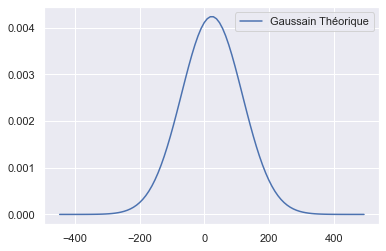

In [248]:
# The swap object 
irs =  IrsPortfolio(4 , first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=[7],
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999)


t= 6.75

Vt = irs.Mtm(t,diff,ZC)


#sns.distplot(Vt, hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 3}, label ='Monte Carlo')
# Plot the PDF.
xmin, xmax = plt.xlim()
ax = np.linspace(xmin, xmax, 100)
p = norm.pdf(ax, np.mean(Vt) ,  np.std(Vt))

m,s = Mtm_law(t,irs, lam, sig,ZC)

x_, x__ = m-5*s , m+5*s
ax_ = np.linspace(x_, x__, 100)
pt =  norm.pdf(ax_, m,s)

#plt.plot(ax,p,label='Gaussain Empirique')
plt.plot(ax_,pt,label='Gaussain Théorique')

plt.legend()
plt.show()

In [250]:
t=6.87
Mtm_law(t,irs, lam, sig,ZC)

(0, 0.0)

In [196]:
[swap.tenor for swap in irs.swaps]

[array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
        5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. ]),
 array([0., 1., 2., 3., 4., 5., 6., 7.])]

In [176]:
    swaps_law = np.array([ swap_law(t,swap, lam, sig,ZC) for swap in irs.swaps]) 
    mean_swaps = swaps_law[:,0]
    std_swaps = swaps_law[:,1]

In [177]:
mean_swaps

array([34.24111925, -0.66415184, 19.28013998, 98.38826473])

In [218]:
 np.mean(Vt) ,  np.std(Vt)

(136.73274018555526, 247.33870236800226)

In [219]:
 Mtm_law(t,irs, lam, sig,ZC)

(-9614.941143264828, 304.3944672690451)

## Using now swap proxy dynamic :

In [83]:
def level(t,swap, diff,ZC):
    return (np.diff(swap.tenor)*diff.ZCB(t,swap.tenor,ZC)[:,1:]).sum(axis=1)
def level_initial(swap,ZC):
    zcb = ZC.initial_zcb_curve(swap.tenor)
    return ((swap.tenor[1:] - swap.tenor[:-1]) * zcb[1:]).sum()

def level_proxy(t,T,s0):
    return (1-np.exp(-s0*(T-t)))/s0
def sigma_bachelier(expiry,swap,sigma,lam,ZC):
    zeroCoupon = lambda t : ZC.initial_zcb_curve(t)

    t_start = swap.tenor[0]
    t_end = swap.tenor[-1]

    level = 0
    level_exp = 0

    for tenor in swap.tenor[1:]:
        level += swap.freq * zeroCoupon(tenor)
        level_exp += swap.freq * zeroCoupon(tenor) * np.exp(-lam * tenor)

    s0 = (zeroCoupon(t_start) - zeroCoupon(t_end)) / level
    g0 = (zeroCoupon(t_start) * np.exp(-lam * t_start) - zeroCoupon(t_end) * np.exp(-lam * t_end)) / (
            zeroCoupon(t_start) - zeroCoupon(t_end)) - level_exp / level
    g0 /= lam

    sigma_etoile = sigma ** 2 * s0**2 * g0 ** 2 * (np.exp(2 * lam * expiry) - 1) / (2 * lam)
    sigma_etoile = np.sqrt(sigma_etoile)
    
    return sigma_etoile
def proxy2_level(t,swap, diff,ZC):
    zcb = diff.ZCB(t,swap.tenor,ZC)
    St=(zcb[:,0] - zcb[:,-1]) / ((swap.tenor[1:] - swap.tenor[:-1]) * zcb[:,1:]).sum()
    T = swap.tenor[-1]
    return ((1-np.exp(-St*(T-t)))/St)


In [61]:
#Let's start for one swap

swaps =  [ (IrsPortfolio(1 , first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=[T],
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999).swaps)[0] for T in ZCR['Time'].values]


In [62]:
df =pd.DataFrame(columns=['Maturities' , 'Swap Rate', 'Level', 'Proxy Level'])

In [112]:
df['Maturities'] = ZCR['Time'].round(2)
df['Swap Rate'] = np.array([ swap.swap_rate(ZC) for swap in swaps])
df['Level'] = np.array([ level_initial(swap,ZC) for swap in swaps])
df['Proxy Level'] = level_proxy(0, df['Maturities'], df['Swap Rate'] )
df.round(3)

,Maturities,Swap Rate,Level,Proxy Level,Level mean,Level std,Proxy2 mean,proxy2 std
0,0.00,0.026,0.248,0.000,0.291,0.016,-0.750,0.0
1,0.08,0.026,0.248,0.080,0.291,0.016,-0.750,0.0
2,0.50,0.023,0.496,0.497,0.580,0.031,-0.500,0.0
3,1.00,0.023,0.986,0.989,1.154,0.057,0.000,0.0
4,2.00,0.024,1.948,1.953,2.282,0.100,1.000,0.0
5,3.00,0.027,2.883,2.883,3.377,0.130,2.000,0.0
6,4.00,0.029,3.785,3.775,4.435,0.146,3.000,0.0
7,5.00,0.032,4.652,4.625,5.451,0.150,4.000,0.0
8,6.00,0.034,5.482,5.433,6.423,0.144,5.000,0.0
9,7.00,0.036,6.273,6.196,7.351,0.127,6.000,0.0


In [113]:
t=5
dft= df
dft['Level mean'] = np.array([ np.mean(level(t,swap, diff,ZC)) for swap in swaps])
dft['Level std'] = np.array([ np.std(level(t,swap, diff,ZC)) for swap in swaps])

dft.round(3)

,Maturities,Swap Rate,Level,Proxy Level,Level mean,Level std,Proxy2 mean,proxy2 std
0,0.00,0.026,0.248,0.000,0.291,0.016,-0.750,0.0
1,0.08,0.026,0.248,0.080,0.291,0.016,-0.750,0.0
2,0.50,0.023,0.496,0.497,0.580,0.031,-0.500,0.0
3,1.00,0.023,0.986,0.989,1.154,0.057,0.000,0.0
4,2.00,0.024,1.948,1.953,2.282,0.100,1.000,0.0
5,3.00,0.027,2.883,2.883,3.377,0.130,2.000,0.0
6,4.00,0.029,3.785,3.775,4.435,0.146,3.000,0.0
7,5.00,0.032,4.652,4.625,5.451,0.150,4.000,0.0
8,6.00,0.034,5.482,5.433,6.423,0.144,5.000,0.0
9,7.00,0.036,6.273,6.196,7.351,0.127,6.000,0.0


In [92]:
def proxy_law(t,irs, lam, sig,ZC): 
    swap = irs.swaps[0]
    s0 = swap.swap_rate(ZC)
    mean = swap.nominal * level_proxy(t,swap.tenor[-1],s0) * (s0-swap.strike)
    
    std = swap.nominal*level_proxy(t,swap.tenor[-1],s0)*sigma_bachelier(t,swap,sig,lam,ZC)
    return mean,std

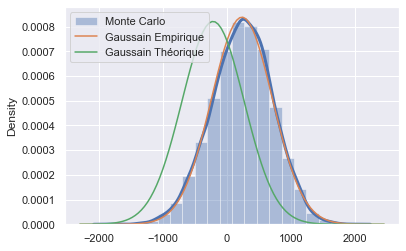

In [111]:
# The swap object 
T=10
irs =  IrsPortfolio(1 , first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=[T],
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999)


t=5
Vt=irs.Mtm(t,diff,ZC)


sns.distplot(Vt, hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 3}, label ='Monte Carlo')
# Plot the PDF.
xmin, xmax = plt.xlim()
ax = np.linspace(xmin, xmax, 100)
p = norm.pdf(ax, np.mean(Vt) ,  np.std(Vt))
m,s = proxy_law(t,irs, lam, sig,ZC)
pt =  norm.pdf(ax, m,s)
plt.plot(ax,p,label='Gaussain Empirique')
plt.plot(ax,pt,label='Gaussain Théorique')

plt.legend()
plt.show()

In [85]:
t=1
dft= df
dft['Level mean'] = np.array([ np.mean(level(t,swap, diff,ZC)) for swap in swaps])
dft['Level std'] = np.array([ np.std(level(t,swap, diff,ZC)) for swap in swaps])
dft['Proxy2 mean'] =  np.array([ np.mean(proxy2_level(t,swap, diff,ZC)) for swap in swaps]) 
dft['proxy2 std'] = np.array([  np.std(proxy2_level(t,swap, diff,ZC)) for swap in swaps])

dft.round(3)




,Maturities,Swap Rate,Level,Proxy Level,Level mean,Level std,Proxy2 mean,proxy2 std
0,0.00,0.026,0.248,0.000,0.254,0.001,-0.750,0.0
1,0.08,0.026,0.248,0.080,0.254,0.001,-0.750,0.0
2,0.50,0.023,0.496,0.497,0.507,0.002,-0.500,0.0
3,1.00,0.023,0.986,0.989,1.009,0.002,0.000,0.0
4,2.00,0.024,1.948,1.953,1.993,0.001,1.000,0.0
5,3.00,0.027,2.883,2.883,2.950,0.009,2.000,0.0
6,4.00,0.029,3.785,3.775,3.873,0.021,3.000,0.0
7,5.00,0.032,4.652,4.625,4.760,0.037,4.000,0.0
8,6.00,0.034,5.482,5.433,5.609,0.056,5.000,0.0
9,7.00,0.036,6.273,6.196,6.419,0.078,6.000,0.0


In [274]:

t=5
Vt=irswap.Mtm(t,diff,ZC)
swap = irswap.swaps[0]
np.mean(Vt) , np.std(Vt)

(-367.4242536664042, 265.6669029281365)

In [275]:
s0=swap.swap_rate(ZC)
swap.nominal*level_proxy(t,s0)*(s0-swap.strike) , (swap.nominal*level_proxy(t,s0)*sigma_bachelier(t,swap,sig,lam,ZC))**2

(-493.4662059657988, 67634.95029967243)

    As we see , freezing level it's not good especially for large t . Maybe good at t_start just for the mean 

A try of the expontial approximation without freezing 

In [313]:
def level(t,swap, diff,ZC):
    return (np.diff(swap.tenor)*diff.ZCB(t,swap.tenor,ZC)[:,1:]).sum(axis=1)

def swap_taux(t,swap, diff,ZC):
    zcb = diff.ZCB(t,swap.tenor,ZC)
    St=(zcb[:,0] - zcb[:,-1]) / ((swap.tenor[1:] - swap.tenor[:-1]) * zcb[:,1:]).sum()
    
    return St

In [319]:
t=0.1
swap = irswap.swaps[0]
level(t,swap, diff,ZC)

array([8.36685733, 8.47849648, 8.39564141, ..., 8.44942527, 8.41970614,
       8.49413145])

<Axes: ylabel='Density'>

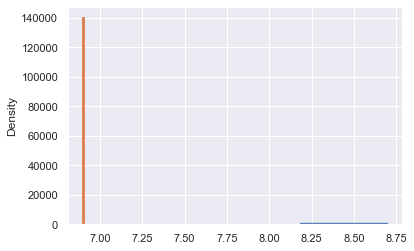

In [320]:
sns.distplot(level(t,swap, diff,ZC), hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 3}, label ='simulated Level')
sns.distplot(proxy_level(t,swap, diff,ZC), hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 3}, label ='Proxy')

In [321]:
np.std(level(t,swap, diff,ZC)) 

0.06047180967104569

In [322]:
np.std(proxy_level(t,swap, diff,ZC))

2.8429018204265677e-06

    Not goood as proxy 

## GPR

In [15]:
# We tested on different values of t
t = 2 #6.14

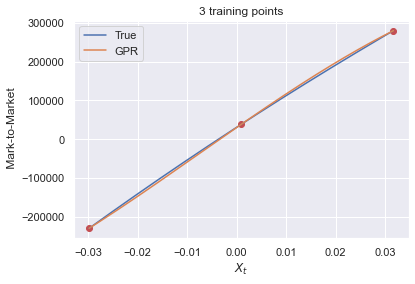

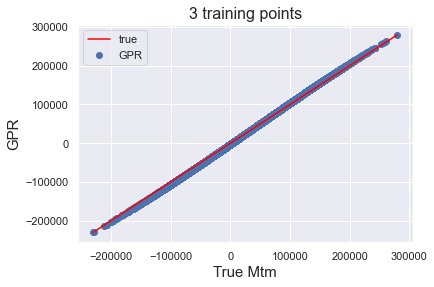

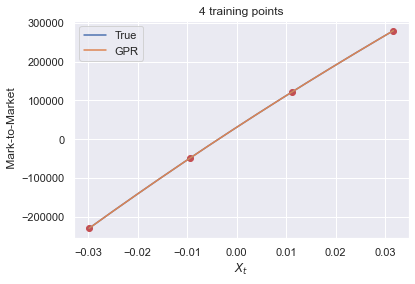

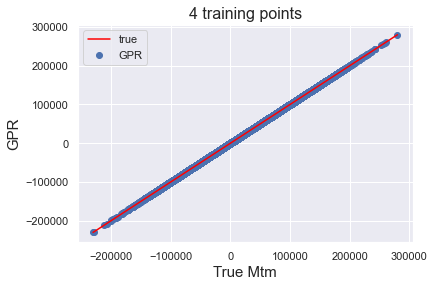

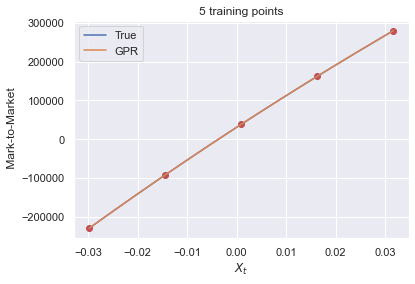

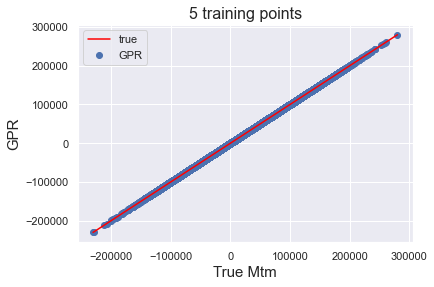

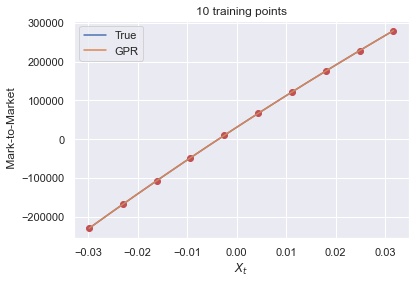

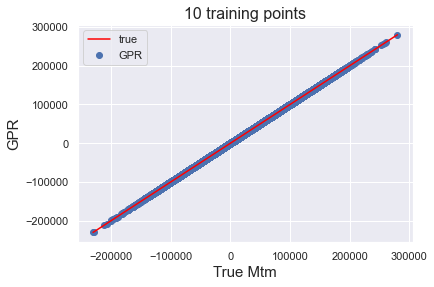

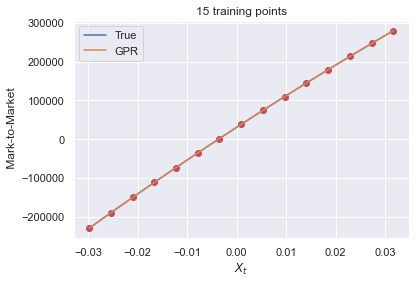

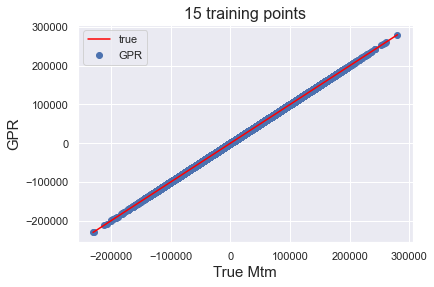

In [16]:
nodes_numbers = [3,4,5,10,15]

for n in nodes_numbers :
    GPR_Mtm_ploter(t, diff, irs, ZC, n)
    GPR_Mtm_ploter(t, diff, irs, ZC, n,True)
    

## Chebyshev

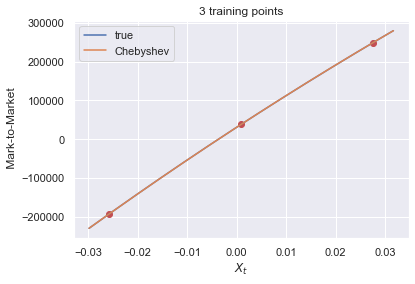

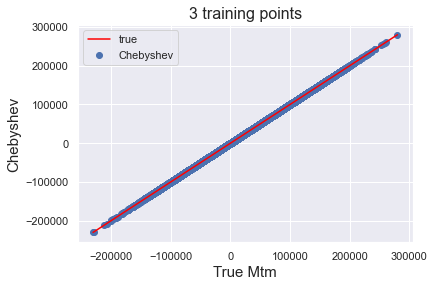

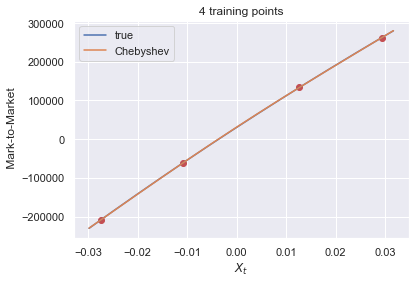

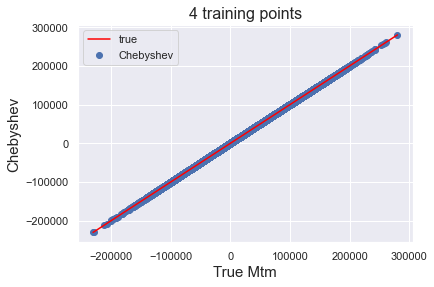

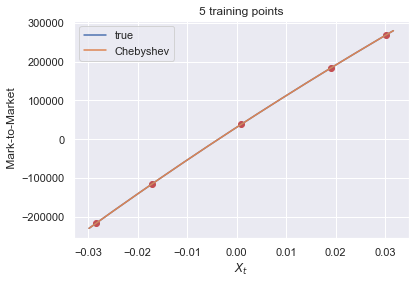

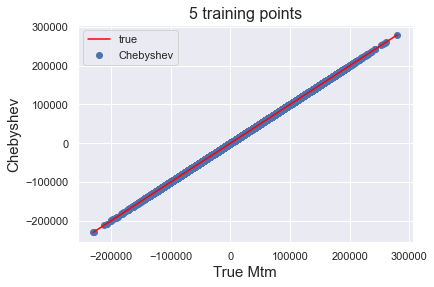

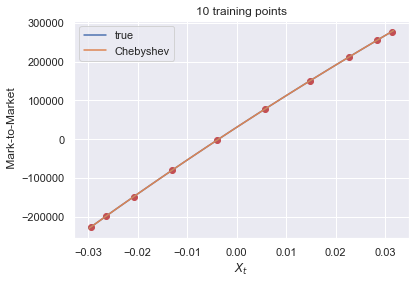

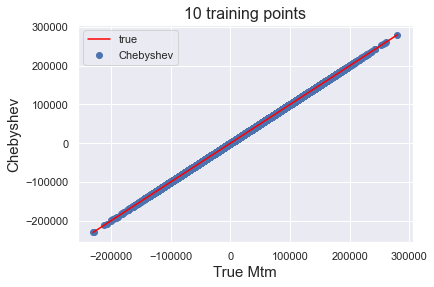

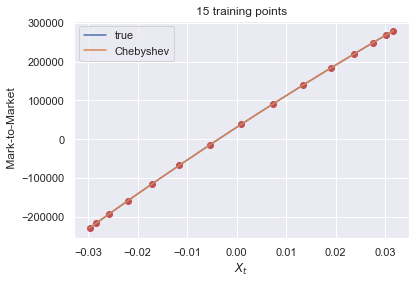

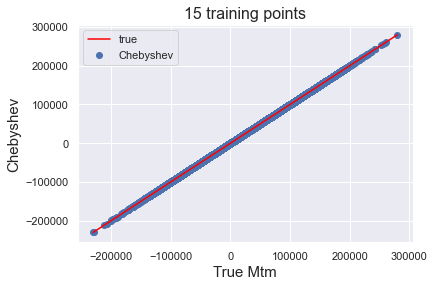

In [17]:
nodes_numbers = [3,4,5,10,15]

for n in nodes_numbers :
    Chebyshev_Mtm_ploter(t, diff, irs, ZC, n)
    Chebyshev_Mtm_ploter(t, diff, irs, ZC, n,True)

    Graphically, it seem that with only a few points (4 for GPR and 3 for Chebyshev) can fit the Mtm wich is quasi-linear 

## Numerical Test :

In [112]:
def MAE(pred, true):
    return np.mean(np.abs(pred-true))
def MRE(pred, true):
    return np.mean(np.abs(pred-true)/np.abs(true))

$MAE := \frac{1}{n} \sum_{i=1}^{n} |Pred_{i} \:  - \; True_i|  \\
MRE := \frac{1}{n} \sum_{i=1}^{n} \frac{|Pred_{i} \:  - \; True_i|}{|True_{i}|}$

In [19]:
nodes_numbers = [3,4,5,10,15]

true_mtm = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
result = pd.DataFrame(columns=['Training','MAE', 'MRE %'])
for n in nodes_numbers :
    pred = GPR_Mtm(t, diff, irs, ZC, n)
    result.loc[len(result)] = [int(n), MAE(pred,true_mtm) , 100*MRE(pred,true_mtm)]
print('gpr Result')
result.round(2)

gpr Result


,Training,MAE,MRE %
0,3.0,2752.28,31.97
1,4.0,6.68,0.10
2,5.0,0.34,0.01
3,10.0,0.06,0.00
4,15.0,0.13,0.00


In [20]:
nodes_numbers = [3,4,5,10,15]

true_mtm = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
result = pd.DataFrame(columns=['Training','MAE', 'MRE %'])
for n in nodes_numbers :
    pred = Chebyshev_Mtm(t, diff, irs, ZC, n)
    result.loc[len(result)] = [int(n), MAE(pred,true_mtm) , 100*MRE(pred,true_mtm)]
print('Chebyshev Result')
result.round(2)

Chebyshev Result


,Training,MAE,MRE %
0,3.0,61.88,0.74
1,4.0,364.29,5.48
2,5.0,12.95,0.19
3,10.0,20.50,0.09
4,15.0,0.48,0.01
